# Colab TPU Setup

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu()

In [1]:
import jax
jax.devices()

[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0)]

# The basics

In [2]:
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

In [5]:
n_devices = jax.local_device_count()
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39]])

In [6]:
ws

array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])

In [8]:
jax.vmap(convolve)(xs, ws)

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)

In [9]:
jax.pmap(convolve)(xs, ws)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)

In [12]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.]], dtype=float32)

# Specifying <code>in_axes</code>

In [13]:
jax.pmap(convolve, in_axes=(0, None))(xs, w)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)

# <code>pmap</code> and <code>jit</code>

<code>jax.pmap</code> JIT-compiles the function given to it as part of its operation fo there is no need to additionally <code>jax.jit</code> it

# Communication between devices

In [14]:
def normalized_convolution(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    output = jnp.array(output)
    return output / jax.lax.psum(output, axis_name='p')

jax.pmap(normalized_convolution, axis_name='p')(xs, ws)

ShardedDeviceArray([[0.00816024, 0.01408451, 0.019437  ],
                    [0.04154303, 0.04577465, 0.04959786],
                    [0.07492582, 0.07746479, 0.07975872],
                    [0.10830861, 0.10915493, 0.10991958],
                    [0.14169139, 0.14084508, 0.14008044],
                    [0.17507419, 0.17253523, 0.1702413 ],
                    [0.20845698, 0.20422536, 0.20040216],
                    [0.24183977, 0.2359155 , 0.23056301]], dtype=float32)

In [16]:
jax.vmap(normalized_convolution, axis_name='p')(xs, ws)

DeviceArray([[0.00816024, 0.01408451, 0.019437  ],
             [0.04154303, 0.04577465, 0.04959786],
             [0.07492582, 0.07746479, 0.07975872],
             [0.10830861, 0.10915493, 0.10991958],
             [0.14169139, 0.14084508, 0.14008044],
             [0.17507419, 0.17253523, 0.1702413 ],
             [0.20845698, 0.20422536, 0.20040216],
             [0.24183977, 0.2359155 , 0.23056301]], dtype=float32)

# Nesting <code>jax.pmap</code> and <code>jax.vmap</code>

In [17]:
jax.vmap(jax.pmap(f, axis_name='i'), axis_name='j')

NameError: name 'f' is not defined

# Example

examples of a regression training loop with data parallelism, where each batch is split into sub-batches which are evaluated on separate devices.

- the <code>update()</code> function
- the replication of parameters and splitting of data across devices.

In [27]:
from typing import NamedTuple
import functools

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray
    

def init(rng) -> Params:
    """Returns the initial model params."""
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())

    return Params(weight, bias)


def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
    """Computes the least squares error of the model's predictions on x against y."""
    pred = params.weight * xs + params.bias
    return jnp.mean((pred - ys) ** 2)

lr = 0.005

# So far, the code is identical to the single-device case. Here's what's new:


# Remember that the `axis_name` is just an arbitrary string label used
# to later tell `jax.lax.pmean` which axis to reduce over. Here, we call it
# 'num_devices', but could have used anything, so long as `pmean` used the same.
@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> Params:
    """Performs one SGD update step on params using the given data"""
    
    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)
    
    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='num_devices')
    
    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='num_devices')
    
    # Each device performs its own update, but since we start with the same params
    # and synchronise gradients, the params stay in sync.
    new_params = jax.tree_multimap(
        lambda param, g: param - g * lr, params, grads)
    
    return new_params, loss

In [28]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = init(jax.random.PRNGKey(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

In [29]:
type(replicated_params.weight)

jaxlib.xla_extension.DeviceArray

In [39]:
def split(arr):
    """Splits the first axis of 'arr' evenly across the number of devices"""
    return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped 'update()'.
x_split = split(xs)
y_split = split(ys)

type(x_split)

numpy.ndarray

In [40]:
def type_after_update(name, obj):
    print(f"after first 'update()', '{name}' is a", type(obj))
    

# Actual training loop.
for i in range(1000):
    
    # This is where the params and data gets communicated to devices:
    replicated_params, loss = update(replicated_params, x_split, y_split)
    
    # The returned 'replicated_params' and 'loss' are now both ShardedDeviceArrays,
    # indicated that they're on the devices.
    # 'x_split', of course, remains a NumPy array on the host.
    if i == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_split', x_split)
        
    if i % 100 == 0:
        # Note that loss is actually an array of shape [num_devices], with identical
        # entries, because each device returns its copy of the loss.
        # So, we take the first element to print it.
        print(f"Step {i:3d}, loss: {loss[0]:.3f}")
        

# Plot results.

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

after first 'update()', 'replicated_params.weight' is a <class 'jax.interpreters.pxla.ShardedDeviceArray'>
after first 'update()', 'loss' is a <class 'jax.interpreters.pxla.ShardedDeviceArray'>
after first 'update()', 'x_split' is a <class 'numpy.ndarray'>
Step   0, loss: 2.123
Step 100, loss: 0.551
Step 200, loss: 0.303
Step 300, loss: 0.263
Step 400, loss: 0.257
Step 500, loss: 0.256
Step 600, loss: 0.256
Step 700, loss: 0.256
Step 800, loss: 0.256
Step 900, loss: 0.256


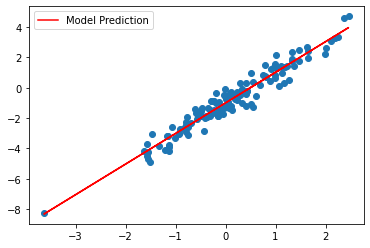

In [41]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()

# Aside: hosts and devices in JAX

In [43]:
jax.devices()

[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0)]